<a href="https://colab.research.google.com/github/amjad-alhaffar/dnnls_final_project/blob/main/Final_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

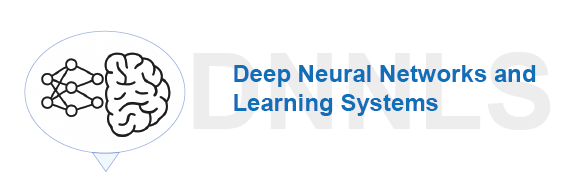

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [2]:
# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [3]:
# @title Setting up google drive to save checkpoints

# This will prompt you to authorize Google Drive access
drive.mount('/content/gdrive')

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    """
    Saves the checkpoint directly to a specified folder in your mounted Google Drive.
    """
    # 1. Define the full Google Drive path
    # 'DL_Checkpoints' is the folder you want to save to inside your Drive
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'

    # Ensure the directory exists before attempting to save
    os.makedirs(drive_folder, exist_ok=True)

    # 2. Combine the folder and the filename
    full_path = os.path.join(drive_folder, filename)

    # 3. Create the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # 4. Save the dictionary to the Google Drive path
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")


def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    """
    Loads a checkpoint from your Google Drive folder into the model and optimizer (if provided).
    """
    # Define the same Google Drive folder path
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)

    # Check if the checkpoint file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    # Load the checkpoint
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))  # use cuda if available

    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer state (if provided)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract metadata
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")

    return model, optimizer, epoch, loss


Mounted at /content/gdrive


We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [4]:
# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Now we load dataset from HuggingFace:

In [5]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

In [6]:
# @title Only Text dataset
class SeqTextPredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer,window_size=5, stride=4):
        super(SeqTextPredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.stride = stride
        self.windows = []
        for story_idx, example in enumerate(self.dataset):
            num_frames = example["frame_count"]
            if num_frames < window_size:
                continue  # skip very short stories

            # sliding windows with given stride
            for start in range(0, num_frames - window_size + 1, self.stride):
                self.windows.append((story_idx, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      story_idx, start = self.windows[idx]
      example = self.dataset[story_idx]

      num_frames = example["frame_count"]
      # frames = example["images"]
      image_attributes = parse_gdi_text(example["story"])

      description_list = []
      obj_list = []
      act_list = []

      for offset in range(self.window_size - 1):
        frame_idx = start + offset
        # Potential experiments: Try using the other attributes in your training
        objects = image_attributes[frame_idx]["objects"]
        actions = image_attributes[frame_idx]["actions"]
        description = image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(
          description,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120
        ).input_ids
        object_ids =  self.tokenizer(
          ", ".join(objects),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids
        action_ids =  self.tokenizer(
          ", ".join(actions),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids

        description_list.append(input_ids.squeeze(0))
        obj_list.append(object_ids.squeeze(0))
        act_list.append(action_ids.squeeze(0))

      target_frame_idx = start + (self.window_size - 1)
      text_target = image_attributes[target_frame_idx]["description"]
      target_ids = self.tokenizer(
          text_target,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120).input_ids.squeeze(0)

      description_tensor = torch.stack(description_list)
      obj_tensor= torch.stack(obj_list)
      act_tensor= torch.stack(act_list)

      return (
              description_tensor,
              obj_tensor,
              act_tensor,
              target_ids,
              )



In [ ]:
# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer,window_size=5, stride=4):
        super(SequencePredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.stride = stride
        # Potential experiments: Try other transforms!
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])
        self.windows = []
        for story_idx, example in enumerate(self.dataset):
            num_frames = example["frame_count"]
            if num_frames < window_size:
                continue  # skip very short stories

            # sliding windows with given stride
            for start in range(0, num_frames - window_size + 1, self.stride):
                self.windows.append((story_idx, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      story_idx, start = self.windows[idx]
      example = self.dataset[story_idx]

      num_frames = example["frame_count"]
      frames = example["images"]
      image_attributes = parse_gdi_text(example["story"])

      frame_tensors = []
      description_list = []
      obj_list = []
      act_list = []

      for offset in range(self.window_size - 1):
        frame_idx = start + offset
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)
        # Potential experiments: Try using the other attributes in your training
        objects = image_attributes[frame_idx]["objects"]
        actions = image_attributes[frame_idx]["actions"]

        description = image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(
          description,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120
        ).input_ids
        object_ids =  self.tokenizer(
          ", ".join(objects),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids
        action_ids =  self.tokenizer(
          ", ".join(actions),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids

        description_list.append(input_ids.squeeze(0))
        obj_list.append(object_ids.squeeze(0))
        act_list.append(action_ids.squeeze(0))

      target_frame_idx = start + (self.window_size - 1)
      image_target = FT.equalize(frames[target_frame_idx])
      image_target = self.transform(image_target)
      text_target = image_attributes[target_frame_idx]["description"]
      target_ids = self.tokenizer(
          text_target,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120).input_ids.squeeze(0)

      sequence_tensor = torch.stack(frame_tensors)
      description_tensor = torch.stack(description_list)
      obj_tensor= torch.stack(obj_list)
      act_tensor= torch.stack(act_list)

      return (sequence_tensor,
              description_tensor,
              obj_tensor,
              act_tensor,
              image_target,
              target_ids,
              )



We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [ ]:
# @title Text Autoencoder Dataset
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.index = []  # list of (story_idx, frame_idx)

        for story_idx, example in enumerate(self.dataset):
            num_frames = example["frame_count"]
            for frame_idx in range(num_frames):
                self.index.append((story_idx, frame_idx))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        story_idx, frame_idx = self.index[idx]
        example = self.dataset[story_idx]

        image_attributes = parse_gdi_text(example["story"])
        description = image_attributes[frame_idx]["description"]

        return description

And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

In [ ]:
# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the autoencoder

      return input_frame, # Returning the image

## 1.3 Creating and testing our dataset objects and loaders


---



In [24]:
# @title For the Sequence prediction task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SeqTextPredictionDataset(train_dataset, tokenizer, window_size=5, stride=3)
sp_test_dataset  = SeqTextPredictionDataset(test_dataset,  tokenizer, window_size=5, stride=3)
print(len(sp_train_dataset))
print(len(sp_test_dataset))
# Let's do things properly, we will also have a validation split
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])
print(sp_train_dataset)
print(sp_test_dataset)

# Instantiate the dataloaders
train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
# We will use the validation set to visualize the progress.
val_dataloader = DataLoader(val_subset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(sp_test_dataset, batch_size=16, shuffle=False)


11458
2009


In [ ]:
 # @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

In [10]:
# @title Testing some of the outputs of the SP dataset
(
    descriptions,
    objects,
    actions,
    target_desc,
) = sp_train_dataset[np.random.randint(0, len(sp_train_dataset))]

print("Description: ", descriptions.shape)
print("Descriptions shape:", descriptions)
print("Objects shape:", objects)
print("Actions shape:", actions)
print("Target desc shape:", target_desc)
# Do some tests on the batches (try with batch size small)
# (
#     frames,
#     descriptions,
#     objects,
#     actions,
#     image_target,
#     target_desc,
#     target_obj,
#     target_act
# ) = next(iter(train_dataloader))
# print(frames.shape)
# print(descriptions.shape)

Description:  torch.Size([4, 120])
Descriptions shape: tensor([[  101,  1996,  3496,  5429,  2153,  2004,  1037,  2158,  1999,  1037,
         26488,  3797,  3344,  1037,  2312,  4874,  2083,  1996, 20981,  5957,
          1012,  1996,  4044,  2815,  3147,  1998, 10368,  1010,  2021,  2002,
          4508,  2006,  2007,  9128,  1012,  1996,  4874,  6454,  3550,  1037,
          2047,  3125,  2030,  3260,  1010,  4439,  2032,  2830,  2750,  1996,
         15314,  1012,  2002,  2333,  2007,  3800,  1010,  2169,  3357,  5026,
          2032,  3553,  2000,  2010,  7688,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     

Train counts by frame_count:
5 frames: 385 stories
6 frames: 267 stories
7 frames: 239 stories
8 frames: 207 stories
9 frames: 170 stories
10 frames: 180 stories
11 frames: 152 stories
12 frames: 139 stories
13 frames: 125 stories
14 frames: 116 stories
15 frames: 109 stories
16 frames: 161 stories
17 frames: 723 stories
18 frames: 334 stories
19 frames: 94 stories
20 frames: 68 stories
21 frames: 62 stories
22 frames: 21 stories


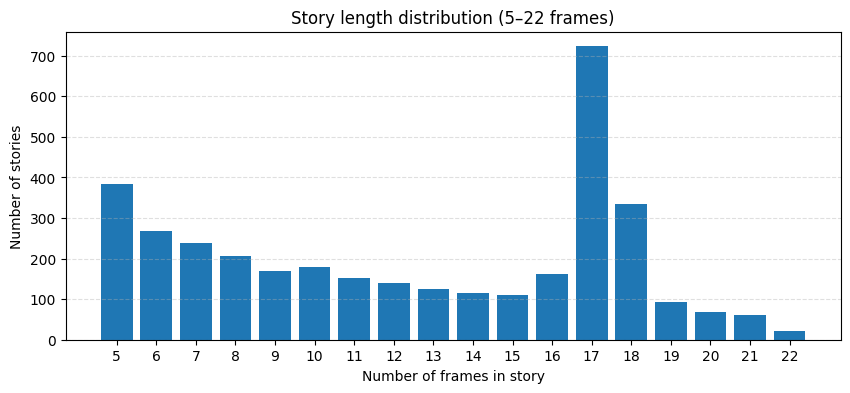

In [ ]:
# @title Data Visualization
from collections import Counter
import matplotlib.pyplot as plt

# Count frames from dataset
frame_counter_train = Counter()
for example in train_dataset:
    num_frames = example["frame_count"]
    frame_counter_train[num_frames] += 1

min_len = min(5)
max_len = max(frame_counter_train.keys())
lengths = list(range(min_len, max_len + 1))
counts = [frame_counter_train.get(l, 0) for l in lengths]
# Plot
plt.figure(figsize=(10, 4))
plt.bar(lengths, counts)
plt.xticks(lengths)
plt.xlabel("Number of frames in story")
plt.ylabel("Number of stories")
plt.title(f"Story length distribution ({min_len}–{max_len} frames)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



We provide a simple text encoder based on a recurrent neural network (LSTM). Feel free to provide your own text encoder.

## 2.1 The NLP models

In [10]:
# @title Bert wrapper
class BertAutoencoderWrapper(nn.Module):
    def __init__(self, bert_mlm_model):
        super().__init__()
        self.bert = bert_mlm_model.bert        # encoder
        self.cls = bert_mlm_model.cls          # MLM head

    def encoder(self, input_ids):
        """
        Returns (dummy_output, hidden, cell)
        We'll use the [CLS] token embedding as 'hidden'.
        """
        outputs = self.bert(input_ids)
        hidden_state = outputs.last_hidden_state
        cls_token = hidden_state[:, 0, :]
        return None, cls_token.unsqueeze(0), None

    def decoder(self, input_ids, h0, c0):
        outputs = self.bert(input_ids)
        sequence_output = outputs.last_hidden_state
        prediction_scores = self.cls(sequence_output)
        # return logits in same format as before
        return prediction_scores, h0, c0


In [ ]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions


In [69]:
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id):
    """
    Autoregressive generation for your BERT-based decoder.
    """

    # Start sequence with [CLS] (SOS)
    generated = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)

    for _ in range(max_len):
        with torch.no_grad():
            # Run the decoder on the current sequence
            logits, _, _ = model(generated, hidden, cell)  # full sequence logits

        # Take only the last token's logits
        next_token_logits = logits[:, -1, :]  # shape: [1, vocab_size]
        penalty = 1.2
        prev_tokens = generated.view(-1).tolist()
        for prev_token in set(prev_tokens):
            next_token_logits[0, prev_token] /= penalty
        # Sample next token
        temperature = 0.7
        probs = torch.softmax(next_token_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)  # shape: [1, 1]
        token_id = next_token.item()

        # Stop if we reach [SEP]
        if token_id == eos_token_id:
            break

        # Avoid appending padding or [CLS]
        if token_id != 0 and token_id != sos_token_id:
            generated = torch.cat([generated, next_token], dim=1)

    return generated.squeeze().tolist()  # return token IDs


In [11]:
# @title Do some tests
desc = text_dataset[np.random.randint(0, 100)]
print(f"Input: {desc}")
input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
input_ids = input_ids.to(device)
generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
print("Output: ", tokenizer.decode(generated_tokens))

NameError: name 'text_dataset' is not defined

## 2.2 The Vision models

In [ ]:
# @title The visual autoencoder
class Backbone(nn.Module):
    """
      Main convolutional blocks for our CNN
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(Backbone, self).__init__()
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=2, padding=3),
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )

        # Calculate flattened dimension for linear layer
        self.flatten_dim = 64 * output_w * output_h
        # Latent space layers
        self.fc1 = nn.Sequential(nn.Linear(self.flatten_dim, latent_dim), nn.ReLU())


    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, self.flatten_dim)  # flatten for linear layer
        z = self.fc1(x)
        return z

class VisualEncoder(nn.Module):
    """
      Encodes an image into a latent space representation. Note the two pathways
      to try to disentangle the mean pattern from the image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualEncoder, self).__init__()

        self.context_backbone = Backbone(latent_dim, output_w, output_h)
        self.content_backbone = Backbone(latent_dim, output_w, output_h)

        self.projection = nn.Linear(2*latent_dim, latent_dim)
    def forward(self, x):
        z_context = self.context_backbone(x)
        z_content = self.content_backbone(x)
        z = torch.cat((z_content, z_context), dim=1)
        z = self.projection(z)
        return z

class VisualDecoder(nn.Module):
    """
      Decodes a latent representation into a content image and a context image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualDecoder, self).__init__()
        self.imh = 60
        self.imw = 125
        self.flatten_dim = 64 * output_w * output_h
        self.output_w = output_w
        self.output_h = output_h

        self.fc1 = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
          nn.GroupNorm(8, 32),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
          nn.GroupNorm(8, 16),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=(1, 1)),
          nn.Sigmoid() # Use nn.Tanh() if your data is normalized to [-1, 1]
      )

    def forward(self, z):
      x = self.fc1(z)

      x_content = self.decode_image(x)
      x_context = self.decode_image(x)

      return x_content, x_context

    def decode_image(self, x):
      x = x.view(-1, 64, self.output_w, self.output_h)      # reshape to conv feature map
      x = self.decoder_conv(x)
      x = x[:, :, :self.imh, :self.imw]          # crop to original size if needed
      return x

class VisualAutoencoder( nn.Module):
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualAutoencoder, self).__init__()
        self.encoder = VisualEncoder(latent_dim, output_w, output_h)
        self.decoder = VisualDecoder(latent_dim, output_w, output_h)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat



## 2.3 The main architecture


In [11]:
# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # This "attention" layer learns a query vector
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1) # Over the sequence length

    def forward(self, rnn_outputs):
        # rnn_outputs shape: [batch, seq_len, hidden_dim]

        # Pass through linear layer to get "energy" scores
        energy = self.attn(rnn_outputs).squeeze(2) # Shape: [batch, seq_len]

        # Get attention weights
        attn_weights = self.softmax(energy) # Shape: [batch, seq_len]

        # Apply weights
        # attn_weights.unsqueeze(1) -> [batch, 1, seq_len]
        # bmm with rnn_outputs -> [batch, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)

        # Squeeze to get final context vector
        return context.squeeze(1) # Shape: [batch, hidden_dim]

In [21]:
# @title The main sequence predictor model

class SequencePredictor(nn.Module):
    def __init__(self, text_autoencoder, latent_dim,
                 gru_hidden_dim):
        super(SequencePredictor, self).__init__()
        # --- 1. Encoders ---
        self.text_encoder = text_autoencoder.encoder
        self.obj_encoder = text_autoencoder.encoder
        self.act_encoder = text_autoencoder.encoder
        # --- 2- projection
        self.text_proj = nn.Linear(768, latent_dim)
        self.obj_proj = nn.Linear(768, latent_dim)
        self.act_proj = nn.Linear(768, latent_dim)


        # --- 2. gate ---
        self.gate_layer = nn.Linear(latent_dim * 2, latent_dim)

        # --- 3. Temporal Encoder ---
        fusion_dim = latent_dim # z_conditions fuse + z_text
        self.temporal_rnn = nn.GRU(fusion_dim, latent_dim, batch_first=True)

        # --- 4. Attention ---
        self.attention = Attention(gru_hidden_dim)

        # --- 4. Final Projection ---
        # cat(h, context) -> gru_hidden_dim * 2

        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )
        # --- 5. Decoders ---
        # (These predict the *next* item)
        self.text_decoder = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, 32)
        self.fused_to_c0 = nn.Linear(latent_dim, 32)

    def forward(self, obj_seq, act_seq, desc_seq, target_seq):
        # text_seq shape:  [batch, seq_len, text_len]
        # target_text_for_teacher_forcing: [batch, text_len] (This is the last text)

        batch_size, seq_len, _ = desc_seq.shape

        # --- 1 & 2: Run Static Encoders over the sequence ---
        # We can't pass a 5D/4D tensor to the encoders.
        # We "flatten" the batch and sequence dimensions.
        # Reshape for text_encoders
        desc_flat = desc_seq.view(batch_size * seq_len, -1) # -1 infers text_len
        obj_flat = obj_seq.view(batch_size * seq_len, -1)
        act_flat = act_seq.view(batch_size * seq_len, -1)

        # Run encoders
        # z_v_flat = self.image_encoder(img_flat) # Shape: [b*s, latent]
        with torch.no_grad():
          _, desc_hidden, _ = self.text_encoder(desc_flat)
          _, obj_hidden, _  = self.obj_encoder(obj_flat)
          _, act_hidden, _  = self.act_encoder(act_flat)

        desc_hidden = desc_hidden.squeeze(0)
        obj_hidden = obj_hidden.squeeze(0)
        act_hidden = act_hidden.squeeze(0)
        # project from BERT latent space using 768
        desc_hidden = self.text_proj(desc_hidden)
        obj_hidden  = self.obj_proj(obj_hidden)
        act_hidden  = self.act_proj(act_hidden)

        # Gating
        cond = torch.cat([obj_hidden, act_hidden], dim=-1) # concatinate objects and actions as one feature
        gate = torch.sigmoid(self.gate_layer(cond)) # gate
        conditioned_desc = desc_hidden * gate  # apply on desc


        # Temporal
        # zseq shape: [b, s, gru_hidden]
        # h    shape: [1, b, gru_hidden]
        conditioned_seq = conditioned_desc.view(batch_size, seq_len, -1)
        zseq, h = self.temporal_rnn(conditioned_seq)
        h = h.squeeze(0)

        # --- 4. Attention ---
        context = self.attention(zseq)

        # --- 5. Final Prediction Vector (z) ---
        z = self.projection(torch.cat((h, context), dim=1)) # Shape: [b, joint_latent_dim]

        # --- 6. Decode (Predict pk) ---

        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:,:-1].squeeze(1)

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predicted_text_logits_k, _, _ = self.text_decoder(decoder_input, h0, c0)
        # return pred_image_content, pred_image_context, predicted_text_logits_k,h0, c0
        return  predicted_text_logits_k,h0, c0

# **Chapter 3: Training routines**


---




In [63]:
# @title Training utility functions: To initialize and to visualize the progress


# def init_weights(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)
#     elif isinstance(m, nn.Linear):
#         nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#         nn.init.constant_(m.bias, 0)


# Plots four images and their reconstructions
def validation(model, data_loader, criterion, max_gen_len=120):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        descriptions, objects, actions, text_target = next(iter(data_loader))

        descriptions = descriptions.to(device, dtype=torch.float32)
        objects = objects.to(device, dtype=torch.float32)
        actions = actions.to(device, dtype=torch.float32)
        text_target = text_target.to(device, dtype=torch.long)

        # Forward
        predicted_logits, h0, c0 = model(objects, actions, descriptions, text_target)

        # Loss
        prediction_flat = predicted_logits.reshape(-1, tokenizer.vocab_size)
        target_labels = text_target[:, 1:]   # shift
        target_flat = target_labels.reshape(-1)

        loss = criterion(prediction_flat, target_flat)
        total_loss += loss.item()
        count += 1
        target_text = tokenizer.decode(text_target[0], skip_special_tokens=True)

        generated_tokens = generate(
            model.text_decoder,
            h0[:, 0, :].unsqueeze(1),
            c0[:, 0, :].unsqueeze(1),
            max_len=max_gen_len,
            sos_token_id=tokenizer.cls_token_id,
            eos_token_id=tokenizer.sep_token_id
        )

        gen_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

        print("\n" + "="*80)
        print("TARGET:")
        print(textwrap.fill(target_text, 100))
        print("\nPREDICTED:")
        print(textwrap.fill(gen_text, 100))
        print("="*80 + "\n")


    return total_loss / count



## 3.1 Initialization and setup

In [14]:
# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_EPOCHS = 25
emb_dim = 32
latent_dim = 32
num_layers = 1
dropout = 0.1

In [ ]:
# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=16)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

Total trainable parameters in visual autoencoder: 503539


In [ ]:
# @title Initialize the main architecture
# We put all the sizes the same, not ideal as well
# sequence_predictor = SequencePredictor(text_autoencoder, latent_dim, latent_dim)
# sequence_predictor.to(device)

# # # Print number of trainable parameters
# total_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
# print(f"Total trainable parameters in the whole model: {total_params}")

# # Print model size
# total_params = sum(p.numel() for p in sequence_predictor.parameters())
# print(f"Total parameters: {total_params}")

Total trainable parameters in the whole model: 507028
Total parameters: 2006958


## 3.2 Training loops

In [47]:
# @title Training tools, before caching Bert

from transformers import BertTokenizer, BertForMaskedLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
N_EPOCHS=50
latent_dim = 128
gru_hidden_dim = 128


tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))


bert_mlm  = BertForMaskedLM.from_pretrained("google-bert/bert-base-uncased")
bert_mlm.load_state_dict(
    torch.load("/content/gdrive/MyDrive/bert_mlm_finetuned.pth", map_location=device)
)

text_autoencoder = BertAutoencoderWrapper(bert_mlm).to(device)
# freeze
for param in text_autoencoder.bert.parameters():
    param.requires_grad = False
bert_trainable = sum(p.numel() for p in text_autoencoder.parameters() if p.requires_grad)
print(f"BERT trainable params: {bert_trainable}")

text_autoencoder.eval()

cuda


Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT trainable params: 622650


BertAutoencoderWrapper(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [31]:
# @title Caching BERT embeddings for train/val/test
from tqdm.auto import tqdm

def cach_data(name, loader):
    desc_embs, obj_embs, act_embs, targets = [], [], [], []
    text_autoencoder.eval()

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Caching {name}"):
            descriptions, objects, actions, text_target = batch
            descriptions = descriptions.to(device)
            objects = objects.to(device)
            actions = actions.to(device)

            # dynamic dims
            b, seq_len, desc_len = descriptions.shape
            obj_len = objects.shape[2]
            act_len = actions.shape[2]

            # flatten first two dims
            desc_flat = descriptions.view(b * seq_len, desc_len)
            obj_flat  = objects.view(b * seq_len, obj_len)
            act_flat  = actions.view(b * seq_len, act_len)

            # run BERT
            desc_out = text_autoencoder.bert(desc_flat).last_hidden_state[:, 0, :].cpu()
            obj_out  = text_autoencoder.bert(obj_flat).last_hidden_state[:, 0, :].cpu()
            act_out  = text_autoencoder.bert(act_flat).last_hidden_state[:, 0, :].cpu()

            # reshape back
            hidden_dim = desc_out.size(-1)  # should be 768
            desc_out = desc_out.view(b, seq_len, hidden_dim)
            obj_out  = obj_out.view(b, seq_len, hidden_dim)
            act_out  = act_out.view(b, seq_len, hidden_dim)

            desc_embs.append(desc_out)
            obj_embs.append(obj_out)
            act_embs.append(act_out)
            targets.append(text_target.cpu())

    # concatenate all
    desc_embs = torch.cat(desc_embs)
    obj_embs  = torch.cat(obj_embs)
    act_embs  = torch.cat(act_embs)
    targets   = torch.cat(targets)

    torch.save({
        "desc": desc_embs,
        "obj": obj_embs,
        "act": act_embs,
        "target": targets
    }, f"/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_{name}.pt")

    print(f"✅ Cached {name} BERT features saved successfully!")

# Run for all
cach_data("train", train_dataloader)
# cach_data("val", val_dataloader)
# cach_data("test", test_dataloader)


Caching train:   0%|          | 0/287 [00:00<?, ?it/s]

✅ Cached train BERT features saved successfully!


In [48]:
# @title Load cached embeddings to speed the training
class CachedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, cache_path):
        data = torch.load(cache_path)
        self.desc = data["desc"]
        self.obj = data["obj"]
        self.act = data["act"]
        self.target = data["target"]

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (
            self.desc[idx],
            self.obj[idx],
            self.act[idx],
            self.target[idx]
        )
class SequencePredictorCached(nn.Module):
    def __init__(self, latent_dim, gru_hidden_dim, vocab_size):
        super().__init__()
        self.text_proj = nn.Linear(768, latent_dim)
        self.obj_proj  = nn.Linear(768, latent_dim)
        self.act_proj  = nn.Linear(768, latent_dim)

        self.gate_layer = nn.Linear(latent_dim * 2, latent_dim)
        self.temporal_rnn = nn.GRU(latent_dim, latent_dim, batch_first=True)
        self.attention = Attention(gru_hidden_dim)
        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )

        # same decoder you used before
        self.text_decoder = text_autoencoder.decoder
        self.fused_to_h0 = nn.Linear(latent_dim, 32)
        self.fused_to_c0 = nn.Linear(latent_dim, 32)

    def forward(self, desc_hidden, obj_hidden, act_hidden, target_seq):
        # each input now already shape [batch, seq_len, 768]
        desc_hidden = self.text_proj(desc_hidden)
        obj_hidden  = self.obj_proj(obj_hidden)
        act_hidden  = self.act_proj(act_hidden)

        cond = torch.cat([obj_hidden, act_hidden], dim=-1)
        gate = torch.sigmoid(self.gate_layer(cond))
        conditioned_desc = desc_hidden * gate

        zseq, h = self.temporal_rnn(conditioned_desc)
        h = h.squeeze(0)

        context = self.attention(zseq)
        z = self.projection(torch.cat((h, context), dim=1))

        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:, :-1].squeeze(1)
        predicted_logits, _, _ = self.text_decoder(decoder_input, h0, c0)
        return predicted_logits, h0, c0

cached_dataset = CachedSequenceDataset("/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_train.pt")
cached_dataset_val = CachedSequenceDataset("/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_val.pt")
cached_dataset_test = CachedSequenceDataset("/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_test.pt")
train_dataloader_c = DataLoader(cached_dataset, batch_size=32, shuffle=True)
val_dataloader_c = DataLoader(cached_dataset_val, batch_size=16, shuffle=True)
test_dataloader_c = DataLoader(cached_dataset_test, batch_size=16, shuffle=False)
sequence_predictor = SequencePredictorCached(
    latent_dim=128,
    gru_hidden_dim=128,
    vocab_size=tokenizer.vocab_size
).to(device)

predictor_trainable = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)

print(f"Predictor trainable params: {predictor_trainable}")
# Print model size
optimizer = torch.optim.Adam(sequence_predictor.parameters(),  lr=0.001)


Predictor trainable params: 468545


In [ ]:
# @title Training loop for the sequence predictor
# Instantiate the model, define loss and optimizer
start_epoch = 0

try:
    sequence_predictor, optimizer, last_epoch, _ = load_checkpoint_from_drive(
        sequence_predictor,
        optimizer,
        filename=f"sequence_predictor{start_epoch}.pth"
    )
    start_epoch = last_epoch + 1
except FileNotFoundError:
    print("Starting from scratch")

sequence_predictor.train()
losses = []

for epoch in range(start_epoch, N_EPOCHS):

    running_loss = 0.0
    for step,(descriptions, objects, actions, text_target)  in enumerate(train_dataloader_c):
      # print(step)
      # Send images and tokens to the GPU
      descriptions = descriptions.to(device)
      act_seq = actions.to(device)
      obj_seq = objects.to(device)
      text_target = text_target.to(device)

      # Predictions from our model
      predicted_text_logits, _, _ = sequence_predictor(descriptions, obj_seq, act_seq, text_target)
      # Computing losses

      # Loss function for the text prediction
      prediction_flat = predicted_text_logits.reshape(-1, tokenizer.vocab_size)
      target_labels = text_target.squeeze(1)[:, 1:] # Slice to get [8, 119]
      target_flat = target_labels.reshape(-1)
      loss = criterion_text(prediction_flat, target_flat)
      # Optimizing
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * descriptions.size(0)

    # checking model performance on validation set
    sequence_predictor.eval()
    val_loss = validation(sequence_predictor, train_dataloader_c, criterion_text)
    print(f"---- Validation on training dataset loss: {val_loss:.4f}")
    val_loss = validation(sequence_predictor, val_dataloader_c, criterion_text)
    print(f"Validation on validation dataset loss: {val_loss:.4f} ----")
    sequence_predictor.train()

    # scheduler.step()
    epoch_loss = running_loss / len(train_dataloader_c.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Loss: {epoch_loss:.4f}')

    if (epoch + 1) % 5 == 0:
      save_checkpoint_to_drive(sequence_predictor, optimizer, epoch+1, epoch_loss, filename=f"sequence_predictor{epoch+1}.pth")
# Do better plots
plt.plot(losses)
plt.show()


Starting from scratch

TARGET:
in the restaurant, man with earphones and elderly woman with glasses sat in silence. he held a cell
phone, awaiting news from man in white shirt. the indoor dining area was no longer a place of
relaxation but a staging ground for a high - stakes game. he was the orchestrator, and man in white
shirt was the pawn who was moving faster than anyone could anticipate.

PREDICTED:
and and,.. a... that. as - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - : - - at in
the the same same same year year year years,,,,,,,,,,,,,,,,,,,,,,,, of of the the the and and
from,,,, every each in in the the for between between between in in,, in in for the the the but.....

---- Validation on training dataset loss: 17.3481

TARGET:
the snow was a relentless force as woman, man with long hair, and woman with blonde hair continued
their journey. " we must find shelter soon, " man with long hair declared, his voice laced with
urgency. the trees stood as silent witnes

In [ ]:
# @title Example text reconstruction task
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
import os

print(os.path.exists("/content/gdrive/MyDrive"))


emb_dim = 32
latent_dim = 32
num_layers = 1
dropout = 0.1

# Don't forget to unfreeze the model!
from transformers import BertTokenizer, BertForMaskedLM
from torch.optim import AdamW

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataset.index = text_dataset.index[:10000]
text_dataloader = DataLoader(text_dataset, batch_size=32, shuffle=True)
tokens = tokenizer(text_dataset[0])
print(len(tokens["input_ids"]))

print("Number of descriptions in training set:", len(text_dataset))
print("Number of batches per epoch:", len(text_dataloader))
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,  # 15% of tokens masked (default)
)


cuda
True
92
Number of descriptions in training set: 10000
Number of batches per epoch: 313


In [ ]:
#original text encoder
# @title Example text reconstruction task

# Don't forget to unfreeze the model!
optimizer = torch.optim.Adam(text_autoencoder.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()  # helps stabilize mixed precision training

N_EPOCHS = 25
for epoch in range(N_EPOCHS):
    text_autoencoder.train()
    epoch_loss = 0.0

    for step, descriptions in enumerate(text_dataloader):
        batch = tokenizer(
            descriptions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        input_ids = batch["input_ids"]

        optimizer.zero_grad()

        # Mixed precision forward + backward
        with autocast():
            outputs = text_autoencoder(input_ids, input_ids)
            loss = loss_fn(
                outputs.reshape(-1, tokenizer.vocab_size),
                input_ids[:, 1:].reshape(-1)
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        if step % 100 == 0:
            print(f"[Epoch {epoch+1}] Step {step} | Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(text_dataloader)
    print(f"Epoch {epoch+1}/{N_EPOCHS} | Avg loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        torch.save(text_autoencoder.state_dict(), f"/content/seq2seq-epoch-{epoch+1}.pth")
        print("saved")

# Final save to Drive
save_checkpoint_to_drive(
    text_autoencoder, optimizer, N_EPOCHS, loss, filename="text_autoencoder_new.pth"
)


/tmp/ipython-input-1094628550.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # helps stabilize mixed precision training
/tmp/ipython-input-1094628550.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1] Step 0 | Loss: 5.6492
[Epoch 1] Step 100 | Loss: 5.4628
[Epoch 1] Step 200 | Loss: 5.2818
[Epoch 1] Step 300 | Loss: 5.0400
Epoch 1/25 | Avg loss: 5.3082
[Epoch 2] Step 0 | Loss: 5.0854
[Epoch 2] Step 100 | Loss: 4.9106
[Epoch 2] Step 200 | Loss: 4.3333
[Epoch 2] Step 300 | Loss: 4.6084
Epoch 2/25 | Avg loss: 4.7326
[Epoch 3] Step 0 | Loss: 4.5255
[Epoch 3] Step 100 | Loss: 4.3557
[Epoch 3] Step 200 | Loss: 4.5406
[Epoch 3] Step 300 | Loss: 4.2378
Epoch 3/25 | Avg loss: 4.3670
[Epoch 4] Step 0 | Loss: 4.2942
[Epoch 4] Step 100 | Loss: 4.2676
[Epoch 4] Step 200 | Loss: 4.0596
[Epoch 4] Step 300 | Loss: 4.1356
Epoch 4/25 | Avg loss: 4.1282
[Epoch 5] Step 0 | Loss: 4.2851
[Epoch 5] Step 100 | Loss: 4.0179
[Epoch 5] Step 200 | Loss: 4.0192
[Epoch 5] Step 300 | Loss: 3.9271
Epoch 5/25 | Avg loss: 3.9590
[Epoch 6] Step 0 | Loss: 3.8582
[Epoch 6] Step 100 | Loss: 3.7631
[Epoch 6] Step 200 | Loss: 3.7258
[Epoch 6] Step 300 | Loss: 4.0124
Epoch 6/25 | Avg loss: 3.8290
[Epoch 7] Step 0

In [ ]:
# @title BERT Model
#BERT MLM model
model = BertForMaskedLM.from_pretrained("google-bert/bert-base-uncased").to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0.0
    num_batches = len(text_dataloader)
    for step, descriptions in enumerate(text_dataloader):
        # Move the "sentences" to device
        batch = tokenizer(
            descriptions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=100
        )
        # Move whole batch dict to device
        batch = {k: v.to(device) for k, v in batch.items()}
        examples = [
            {"input_ids": ids, "attention_mask": mask}
            for ids, mask in zip(batch["input_ids"], batch["attention_mask"])
        ]
        masked_batch = data_collator(examples)
        masked_batch = {k: v.to(device) for k, v in masked_batch.items()}
        outputs = model(**masked_batch)

        loss = outputs.loss
        optimizer.zero_grad()

        # outputs = text_autoencoder(input_ids, input_ids)
        # compute the loss: compare 3D logits to 2D targets
        # loss = loss_fn(outputs.reshape(-1, tokenizer.vocab_size), input_ids[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 50 == 0:
          print(f"[Epoch {epoch+1}] Step {step}/{num_batches} | Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1}/{N_EPOCHS}; Avg loss {epoch_loss/len(text_dataloader)}; Latest loss {loss.item()}")
    torch.save(model.state_dict(), "/content/drive/MyDrive/bert_mlm_finetuned.pth")

# saving checkpoint to drive
# save_checkpoint_to_drive(model, optimizer, 3*N_EPOCHS, loss, filename = "model.pth")

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[Epoch 1] Step 0/313 | Loss: 2.0236
[Epoch 1] Step 50/313 | Loss: 1.1548
[Epoch 1] Step 100/313 | Loss: 1.2742
[Epoch 1] Step 150/313 | Loss: 0.9993
[Epoch 1] Step 200/313 | Loss: 1.0714
[Epoch 1] Step 250/313 | Loss: 1.0001
[Epoch 1] Step 300/313 | Loss: 0.8623
Epoch 1/3; Avg loss 1.082791317766086; Latest loss 0.9988994598388672
[Epoch 2] Step 0/313 | Loss: 1.0485
[Epoch 2] Step 50/313 | Loss: 0.9572
[Epoch 2] Step 100/313 | Loss: 0.8641
[Epoch 2] Step 150/313 | Loss: 1.0075
[Epoch 2] Step 200/313 | Loss: 0.7285
[Epoch 2] Step 250/313 | Loss: 0.9568
[Epoch 2] Step 300/313 | Loss: 0.8434
Epoch 2/3; Avg loss 0.8931083964844482; Latest loss 0.7639030814170837
[Epoch 3] Step 0/313 | Loss: 0.8155
[Epoch 3] Step 50/313 | Loss: 0.7612
[Epoch 3] Step 100/313 | Loss: 0.7901
[Epoch 3] Step 150/313 | Loss: 0.8095
[Epoch 3] Step 200/313 | Loss: 0.7179
[Epoch 3] Step 250/313 | Loss: 0.8182
[Epoch 3] Step 300/313 | Loss: 0.8370
Epoch 3/3; Avg loss 0.8143355625506026; Latest loss 0.8507013916969299

OSError: [Errno 107] Transport endpoint is not connected: '/content/gdrive/MyDrive'

# **Polt the restuls we got**

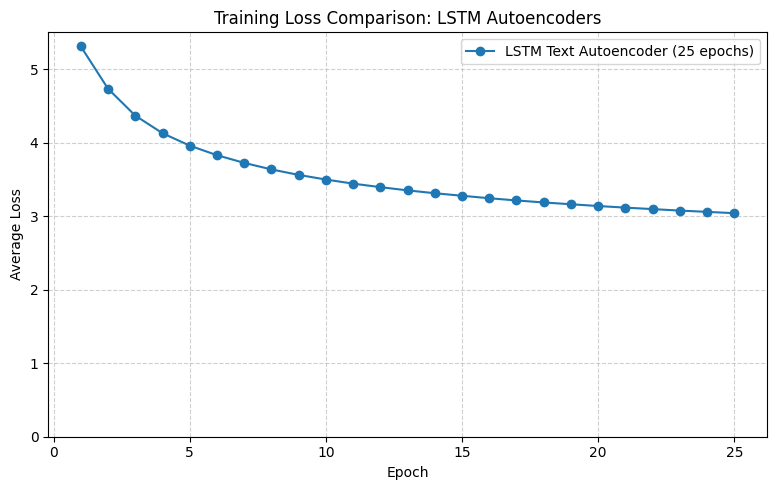

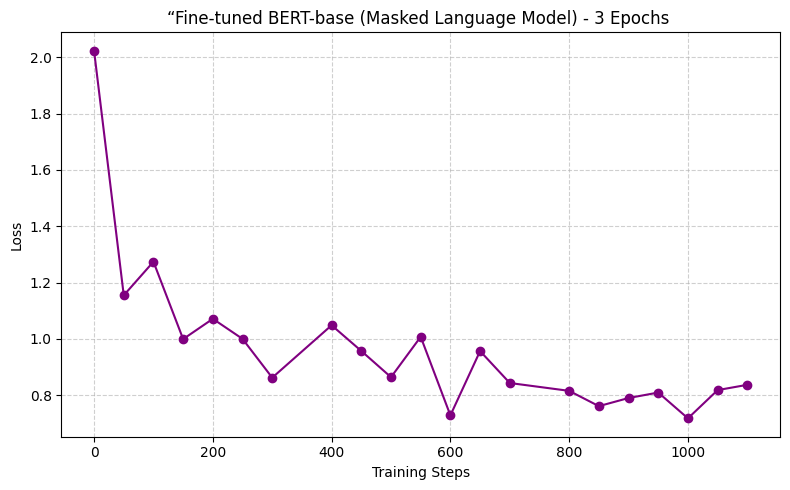

In [1]:
import matplotlib.pyplot as plt
###### got those values output from previous cells ######
bert_steps = [
    0, 50, 100, 150, 200, 250, 300,   # Epoch 1
    400, 450, 500, 550, 600, 650, 700,  # Epoch 2
    800, 850, 900, 950, 1000, 1050, 1100  # Epoch 3
]
bert_losses = [
    2.0236, 1.1548, 1.2742, 0.9993, 1.0714, 1.0001, 0.8623,   # Epoch 1
    1.0485, 0.9572, 0.8641, 1.0075, 0.7285, 0.9568, 0.8434,   # Epoch 2
    0.8155, 0.7612, 0.7901, 0.8095, 0.7179, 0.8182, 0.8370    # Epoch 3
]
# --- LSTM Autoencoder (25 epochs) ---
lstm_avg_losses = [
    5.3082, 4.7326, 4.3670, 4.1282, 3.9590,
    3.8290, 3.7244, 3.6355, 3.5609, 3.4980,
    3.4421, 3.3944, 3.3505, 3.3118, 3.2771,
    3.2437, 3.2135, 3.1861, 3.1618, 3.1377,
    3.1159, 3.0957, 3.0756, 3.0584, 3.0402
]

epochs_lstm = range(1, 26)

# --- Plot both ---
plt.figure(figsize=(8,5))
plt.plot(epochs_lstm, lstm_avg_losses, marker='o', label='LSTM Text Autoencoder (25 epochs)')
# plt.plot(epochs_bert, bert_avg_losses, marker='s', label='Fine-tuned BERT (3 epochs)')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Comparison: LSTM Autoencoders")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0, 5.5)   # show full 0–5 range on y-axis
plt.yticks(range(0, 6))   # tick marks at 0,1,2,3,4,5
plt.show()
#Plot BERT results

# Plot
plt.figure(figsize=(8,5))
plt.plot(bert_steps, bert_losses, marker='o', linestyle='-', color='purple')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("“Fine-tuned BERT-base (Masked Language Model) - 3 Epochs ")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# @title Image reonstruction task

# To-Do: Use previous labs if you want to pretrain your visual encoder

# **Appendix**

This code computes the average images in case you want to use them. Notice that the average should be all zeros!

In [ ]:
# @title Computing and showing average images
N = 1000
H, W = 60, 125

# Tensors to accumulate sum (for mean) and sum of squares (for variance)
avg_images = [torch.zeros((3, H, W)) for _ in range(5)]
sum_sq_diff = [torch.zeros((3, H, W)) for _ in range(5)] # Placeholder for variance numerator
transform = transforms.Compose([transforms.ToTensor()])

# --- First Pass: Calculate the Sum (for Mean) ---
print("Starting Pass 1: Calculating Mean...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])
        avg_images[j] += image # Sum for mean

# Final step for mean
for j in range(5):
    avg_images[j] /= N

print("Starting Pass 2: Calculating Variance...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])

        # Calculate (Image - Mean)^2
        # Note: We detach the mean from the computation graph if it were being trained,
        # but here we're just using it as a fixed statistical value.
        diff = image - avg_images[j]
        sum_sq_diff[j] += diff * diff # Element-wise squaring

# --- Final step for Standard Deviation ---
std_images = []
for j in range(5):
    # Variance = Sum of Squared Differences / N
    variance = sum_sq_diff[j] / N

    # Standard Deviation = sqrt(Variance)
    std_dev = torch.sqrt(variance)
    std_images.append(std_dev)

print("Computation Complete. std_images is a list of 5 tensors (3x60x125).")
# You now have the 5 tensors you need for normalization (mean and std).

fig, ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
  avg_image = avg_images[i]

  # Printing range of avg_image
  print(torch.min(avg_image), torch.max(avg_image))

  avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
  show_image(ax[i], avg_imagen)

# Create a matrix of images with the differences between avg_images
fig, ax = plt.subplots(5,5, figsize=(15,8))

for i in range(5):
  for j in range(5):
    if i == j:
      avg_image = avg_images[i]
      avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
      show_image(ax[i,j], avg_imagen)
    else:
      diff = avg_images[i] - avg_images[j]
      diff = (diff - torch.min(diff))/(torch.max(diff) - torch.min(diff))
      show_image(ax[i,j], diff)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
plt.tight_layout()
plt.subplots_adjust(
    wspace=0, # Set horizontal space to zero
    hspace=0  # Set vertical space to zero
)